# MNIST 手寫數字資料集辨識 by 多層感知機(MLP)

* `MNIST`資料集是由10個數字label所構成，每張圖片是由$28 \times 28$ `pixels`的`matrix`所構成，其中每個`pixels`的值範圍在`0~255`之間([URL](https://zh.wikipedia.org/wiki/%E6%95%B0%E5%AD%97%E5%9B%BE%E5%83%8F))，而每張圖片都是黑白的，所以其顏色通道$channel$是$1$，若是彩色$RGB$，其顏色通道為$3$，而我們想要辨識圖片是屬於哪一個數字，所以這是一個`classification`問題。

接下來將使用`tensorflow`建構最基礎的多層感知機(Multiple Layer Perceptron)來辨識手寫辨識資料集。

In [253]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

### [資料集介紹](http://yann.lecun.com/exdb/mnist/)

首先要將`MNIST`資料集下載下來，其中`keras`已經能夠使用`datasets`類來呼叫函數下載`MNIST`資料集，所以我們不需要直接點上方網址下載。

In [239]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### CH1

`training set`共有$60000$張圖片，每張圖片由一個$28\times28$的矩陣所組成

`testing set`有$10000$張圖片，每張圖片一樣由$28\times28$的矩陣所組成

兩者的`label`種類為`0 1 2 3 4 5 6 7 8 9`，共10種，且各類別數量都挺均勻的

In [263]:
print('---training data---')
print('X_train.shape: ',X_train.shape)
print('y_train.shape: ',y_train.shape)
print('training label: ',np.unique(y_train))
print(dict(zip(np.unique(y_train),np.bincount(y_train))))
print('---testing data---')
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)
print('testing label: ',np.unique(y_test))
print(dict(zip(np.unique(y_test),np.bincount(y_test))))

---training data---
X_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
training label:  [0 1 2 3 4 5 6 7 8 9]
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
---testing data---
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)
testing label:  [0 1 2 3 4 5 6 7 8 9]
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


接著我們試著畫出一張數字圖片來觀察

其中`plt.imshow`的`cmap`參數表示我們要輸出的`colormap`是什麼，所有種類的`colormap`可以參考此[網址](https://matplotlib.org/tutorials/colors/colormaps.html)

因為是黑白圖片，所以我們`cmap`使用`Greys`

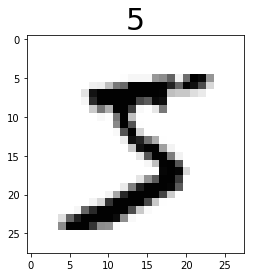

In [245]:
plt.gca()
plt.imshow(X_train[0], cmap='Greys')
plt.title(y_train[0],size = 30)
plt.show()

## Data preprocessing

對於`MLP`來多，一次輸入必須為一個向量，也就是一個$1$維$vector$，而我們的圖片是$matrix$是$2$維的，必須把每張圖片使用`reshape`將$matrix$轉成$vector$

In [203]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28 * 28).astype('float32')
print('---training data---')
print('X_train.shape: ',X_train.shape)
print('---testing data---')
print('X_test.shape: ',X_test.shape)

---training data---
X_train.shape:  (60000, 784)
---testing data---
X_test.shape:  (10000, 784)


## Normalization

接下來這個步驟是為了確保`MLP`中的`backpropagation`時不容易產生梯度消失`(gradient vanishing)`。

In [204]:
x_Train_norm = X_train/255
x_Test_norm = X_test/255

### 為何要Normalization？ (在此盡量減少數學描述)

在`MLP`中，一定會使用`backpropagation`來求得梯度，接著再使用`gradient descent`或是其他`optimizer`來更新參數。

![1](neural_net.jpeg)

對於一個兩層的神經網絡來說(這裏不爭論`input layer`到底算不算一層`layer`)，當`input vector`通過兩個`weighted matrix`與兩個`activation function`得到`output`時，我們會透過`output`與`true`計算`loss`，然後再`backprogation`回來更新所有參數，其中`backpropagation`使用的`chain rule`在計算`activation function`的偏微分時，就能夠了解到`input`是否會造成梯度消失。

#### 對於兩層的神經網路，其`back propagation`的`chain rule`可以簡略的用下式來表示：

求$w_1$的梯度

$$
\begin{align}
\frac{\partial{C}}{\partial{W_1}} 
&= 
\frac{\partial{C}}{\partial{a_2}}
\frac{\partial{a_2}}{\partial{z_2}}
\frac{\partial{z_2}}{\partial{a_1}}
\frac{\partial{a_1}}{\partial{z_1}}
\frac{\partial{z_1}}{\partial{w_1}}\\
&=
\frac{\partial{C}}{\partial{a_2}}
\sigma'(z_2)
w_2
\sigma'(z_1)
X
\end{align}
$$

其中我們需要注意的是$\sigma'$的部分，這個$\sigma'$表示對`activation function`的微分，這個值的大小會決定我們的梯度是否消失，我們舉一個最常見的`activation function`：`sigmoid function`

![](derivative_sigmoid.png)

Take by [url](http://kawahara.ca/how-to-compute-the-derivative-of-a-sigmoid-function-fully-worked-example/)

上圖藍線表示`sigmoid`的曲線，紅線表示`sigmoid`微分後的曲線就是$\sigma'$，我們最關切的是帶入`x`後，`y`的值會不會變得太小，例如我們帶`x=10`，得到的`y`值趨近於$0$，然後再把$0$帶入上面的`chain rule`，就會發現整個$\frac{\partial{C}}{\partial{W1}}$變得更小，然後用$w_1$去減這個很小的值更新$w_1$，會發現$w_1$幾乎沒有更新，這就是梯度消失其中一個最主要的原因。

而接下來的`Normalization`是一種確保值範圍的手段，對於上圖`sigmoid`來說，我希望我的值為在`-4~4`之間最好，因為這樣我才有梯度可以更新，而如果我們沒有`Normalization`的話，對於圖片來說定義域介在`0~255`之間，我們傳遞到最後的`output layer`也會很大，在使用`backpropagation`計算梯度時，傳入的值太大會導致$\sigma'$太小，而導致整個梯度更小，接著參數$w_i$就幾乎不會動了，如果我們先針對圖片的`piexl`預處理，同時除以`255`，將定義域規範在`0~1`之間，這樣在`backpropagation`時才不會使$\sigma'$的值非常小，進而可以更新參數$w_i$。

## One-hot encoding

接下來對label做預處理，原本標籤是`0~9`之間的數字共10種，而神經網絡最後輸出是一個`neuron`對於一種數字的機率是多少，所以我們必須處理成可以讓神經網絡做判斷的資料格式，也就是`One-hot encoding`。

![one_hot](one-hot.png)
Take by [url](https://indianpythonista.wordpress.com/2017/08/06/softmax-regression-using-tensorflow/)

我們直接使用`keras`中`utils`類的`np_utails`類函數`to_categorical`來轉換`One-hot encoding`

In [205]:
from keras.utils import np_utils
y_trainOnehot = np_utils.to_categorical(y_train)
y_testOnehot = np_utils.to_categorical(y_test)

In [225]:
lr = 1e-4 # 控制每一次梯度更新的大小
epoch = 15 # 要訓練整筆數據(60000筆)訓練15次
batch_size = 32 # 每次訓練拿出32筆訓練，所以每個epoch會訓練 60000/32 次

# Modeling

接下來我們使用`tensorflow`來建構一個三層的`MLP`

`Input layer`$\rightarrow$ `Hidden1` $\rightarrow$ `Hidden2` $\rightarrow$ `Ouput layer`

## Tensorflow Graph計算圖

計算圖的概念就是，先將設計圖畫好，最後再將資料丟進去。

* `x=tf.placeholder()`: 這個參數是如同計算圖中負責擔任接收資料的角色。
    * `shape=[None, x_Train_norm.shape[1]]`就是`[None,784]`, 前面的`None`代表一次要輸入幾個`vector`進來，而每個`vector`的維度都是`784`
    * `dtype=tf.float32`：在tensorflow中全部都是進行浮點數運算，很少碰到整數的，而且`tf.float32`與`tf.int32`是沒辦法進行基本運算的，例如`tf.float32`的`constant`與`tf.int32`的`constant`是沒辦法加減乘除的，需要把所有的`dtype`都設定一樣。
    
`y_true`的部分與`x`類似，每次計算`loss`都是`None`個`vector`，每個`vector`都是`10`維的`One-hot encoding`。

## Parameters

接下來將定義參數

* `w1`：看`w1`的`shape`就知道這是一個`matrix`，他的效果是針對`x`這個`input`做線性變換

![](layer operation.png)

Take by myself

如上圖表示，`w`針對`a`(就是指這裏的`x`)做線性變換再加上`bias`。

In [226]:
# 這裏需要注意到，tf.placeholder與參數的設定必須放在同一個cell裡面，分開放會出現shape match不上的問題。

# 確保每次重新執行時的計算圖都是乾淨的
tf.reset_default_graph()

# 設定placeholder
x = tf.placeholder(shape=(None, x_Train_norm.shape[1]), dtype=tf.float32) 
y_true = tf.placeholder(shape=(None, y_trainOnehot.shape[1]), dtype=tf.float32)

# 推薦使用這種寫法，這樣最後訓練時可以印出參數觀察變化
#----hidden layer1------
w1 = tf.get_variable('w1',shape=[x_Train_norm.shape[1],1024],
                     dtype=tf.float32,
                     initializer=tf.truncated_normal_initializer(stddev=0.01))
b1 = tf.get_variable('b1',shape=[1024],
                     dtype=tf.float32,
                     initializer=tf.constant_initializer(0.0))
h1_out = tf.nn.relu(tf.matmul(x, w1) + b1) # 也可以使用tf.add來實現加法
#----hidden layer2------
w2 = tf.get_variable('w2',shape=[1024,512],
                    dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.01))
b2 = tf.get_variable('b2',shape=[512],
                     dtype=tf.float32,
                     initializer=tf.constant_initializer(0.0))
h2_out = tf.nn.relu(tf.matmul(h1_out,w2) + b2)
#----output layer-------
w3 = tf.get_variable('w3',shape=[512,10],
                    dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.01))
b3 = tf.get_variable('b3',shape=[10],
                     dtype=tf.float32,
                     initializer=tf.constant_initializer(0.0))
logits = tf.matmul(h2_out,w3) + b3

定義完`paramaters`之後，接下來是定義`loss function`

## Softmax cross entropy

這個`loss function`由兩個部分組成，第一個部分是負責計算概率值的`softmax`以及負責評估概率值的`cross entropy`

* `softmax`：

![softmax](softmax.jpg)

Take by [youtube](https://youtu.be/hSXFuypLukA?t=3163)

`softmax`可以幫助我們將值之間做概率的轉換，使得每個`neuron`的`output`總和為$1$，這樣計算上相對方便，但是需要注意，這個概率不是真正的機率。

而使用`softmax`真正的原因是為了配合`cross entropy`，`cross entropy`的公式如下：

$$
H(y_{pred},y_{true}):=-\sum_iy_{true}\log(y_{pred})
$$

`cross entropy`是信息理論中計算一個事件其機率所帶來的訊息量有多大的公式，而且計算上也相對容易，我們前面已經針對`label`做`One-hot encoding`了，`One-hot encoding`中只有一個值為$1$，其餘為$0$，所以當帶入`cross entropy`時，只會有一個位置需要計算，我們從數學上來解釋為何會這樣

---

假設我們的神經網路的`output layer`有$3$個`neuron`即$3$個`output`，假設我們已經使用`softmax`來轉換，那麼這裏我們再假設這一個`label`的`One-hot encoding`中，$1$的位置在第二個，其餘為$0$，所以帶入`cross entropy`後如下：

$$
\begin{align}
-\sum_iy_{true}\log(y_{pred})
&=
-(0\times log(0.2) + 1\times log(0.9) + 0\times log(0.1))\\
&=-log(0.9)=0.04575
\end{align}
$$

我們最終得到的`loss`是$0.04575$，這是因為我們的輸出概率`0.9`與真實值`1`很接近，可以嘗試將`0.9`換成`0.5`，會發現`loss`提高很多。

下圖是定義域介在`0~1`之間的`-log`曲線，我們可以發現`y`是隨著`x`增加而遞減的，可以想成當我的概率越接近`1`時，我的`loss`就越小。

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


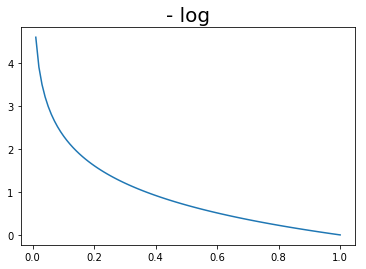

In [227]:
x_plot = np.linspace(0,1,100)
y = -np.log(x_plot)
plt.plot(x_plot,y)
plt.title('- log',size=20)
plt.show()

## Loss function

扯遠了，現在回來定義我們的`loss function`

定義完`loss function`並得到`loss`之後，使用`optimizer`來最小化`loss`，所謂的`optimizer`是用來決定我們的`loss`要如何降低的方法，有許多的方法，在此不細講，但是目前最主流的`optimizer`是`Adam`，他繼承了前幾個`optimizer`算法的優點而來。

[All optimizer url](https://www.tensorflow.org/api_guides/python/train)

In [228]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true))
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

## 評價模型 Accuracy

accuracy是評估預測值與真實值的指標，`tf.argmax`顯示在$10$個`output`中概率值最高的位置，並由`tf.equal`得到`boolean`值，然後透過`tf.cast`轉換成數字，`True`為$1$，`False`為$0$，接著取其平均得到`True`的比例。

In [229]:
correct_pred = tf.equal(tf.argmax(tf.nn.softmax(logits=logits),1),tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32)) # 

# Fit

我們已經定義好計算圖的計算流程，接下來就是訓練模型。

資料的輸入$\rightarrow$參數的設置$\rightarrow$損失函數、優化函數$\rightarrow$預測。

`Accuracy,loss`又分成在`training set`、`validation set`以及`testing set`的準確度，我們通常會在每個`epoch`紀錄一次`trianing set`和`validation set`的`Accuracy,loss`，最後在預測`testing set`。

但是我這裡不將`training set`拆成`validation set`，我選擇直接配合`testing set`來調整參數，每個`epoch`顯示一次`training set`以及`testing set`的準確度。

In [265]:
train_loss_ls, train_acc_ls = [], []
test_loss_ls, test_acc_ls = [], []
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(epoch):
        x_Train_norm, y_trainOnehot = shuffle(x_Train_norm, y_trainOnehot) # 在訓練每個epoch之前打亂順序
        total_batch = int(x_Train_norm.shape[0] / batch_size) # 每個epoch需要訓練幾個batch
        train_loss_batch, train_acc_batch = [], [] # 儲存每個batch_size的結果
        for j in np.arange(total_batch):
            #-----get batch data----
            batch_idx_strt = j * batch_size
            batch_idx_end = (j+1) * batch_size
            
            x_train_batch = x_Train_norm[batch_idx_strt:batch_idx_end]
            y_train_batch = y_trainOnehot[batch_idx_strt:batch_idx_end]
            #------------------------
            _, train_loss, train_acc = sess.run([train_op, loss, accuracy],feed_dict={x:x_train_batch, y_true:y_train_batch})
            train_loss_batch.append(train_loss) # 每一個batch size紀錄一次loss
            train_acc_batch.append(train_acc)  # 每一個batch size紀錄一次accuracy
        
        train_loss_batch = np.mean(train_loss_batch) # 當跑完一個epoch，裡面記錄的是total_batch個loss以及accuracy
        train_acc_batch = np.mean(train_acc_batch) # 這裏取其平均，表示平均每個batch_size的表現，也就是一個epoch的表現
        
        train_loss_ls.append(train_loss_batch) # 將每個batch結果紀錄在list裡面
        train_acc_ls.append(train_acc_batch)
        
        # 每訓練完一個epoch就預測一次testing set的表現
        test_loss, test_acc, test_pred = sess.run([loss, accuracy, logits],feed_dict={x:x_Test_norm, y_true:y_testOnehot})
        test_loss_ls.append(test_loss)
        test_acc_ls.append(test_acc)
        
        print('Epoch: %d/%d' % (i+1, epoch),'\n',
              'train_loss: %.4f' % train_loss_batch, 'train_acc: %.4f' % train_acc_batch,' \ '
              'test_loss: %.4f' % test_loss, 'test_acc: %.4f' % test_acc)
                    

Epoch: 1/15 
 train_loss: 0.4483 train_acc: 0.8767  \ test_loss: 0.2462 test_acc: 0.9275
Epoch: 2/15 
 train_loss: 0.2074 train_acc: 0.9403  \ test_loss: 0.1598 test_acc: 0.9520
Epoch: 3/15 
 train_loss: 0.1425 train_acc: 0.9569  \ test_loss: 0.1250 test_acc: 0.9630
Epoch: 4/15 
 train_loss: 0.1047 train_acc: 0.9689  \ test_loss: 0.0962 test_acc: 0.9700
Epoch: 5/15 
 train_loss: 0.0800 train_acc: 0.9764  \ test_loss: 0.0825 test_acc: 0.9747
Epoch: 6/15 
 train_loss: 0.0624 train_acc: 0.9814  \ test_loss: 0.0807 test_acc: 0.9745
Epoch: 7/15 
 train_loss: 0.0502 train_acc: 0.9848  \ test_loss: 0.0726 test_acc: 0.9774
Epoch: 8/15 
 train_loss: 0.0389 train_acc: 0.9886  \ test_loss: 0.0709 test_acc: 0.9782
Epoch: 9/15 
 train_loss: 0.0310 train_acc: 0.9909  \ test_loss: 0.0697 test_acc: 0.9787
Epoch: 10/15 
 train_loss: 0.0252 train_acc: 0.9927  \ test_loss: 0.0651 test_acc: 0.9801
Epoch: 11/15 
 train_loss: 0.0193 train_acc: 0.9948  \ test_loss: 0.0663 test_acc: 0.9793
Epoch: 12/15 
 trai

## Plot Loss and Accuracy

每個`epcoh`紀錄一次`loss`以及`accuracy`，其中在`training set`上的準確率最高可以達到`0.99`，而`testing set`則是`0.98`

下左圖的`loss`方面差不多到了第$5$個`epoch`時，`testing set`的`loss`就已經趨於平緩，而在`Accuracy`方面也是一樣達到了極限。

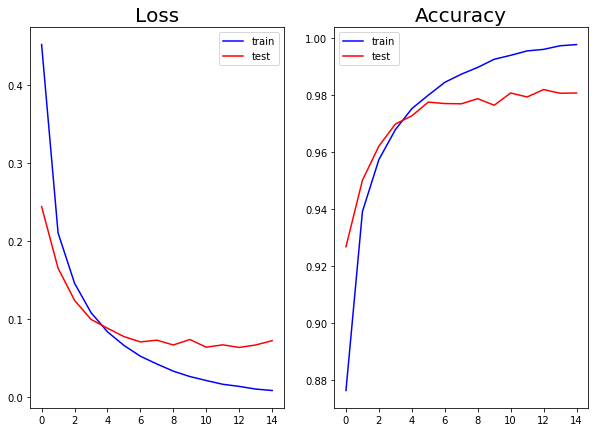

In [247]:
rcParams['figure.figsize'] = (10,7)
plt.subplot(1,2,1)
plt.plot(np.arange(epoch), train_loss_ls, 'b', label='train')
plt.plot(np.arange(epoch), test_loss_ls, 'r', label='test')
plt.legend()
plt.title('Loss',size = 20)

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), train_acc_ls, 'b', label='train')
plt.plot(np.arange(epoch), test_acc_ls, 'r', label='test')
plt.legend()
plt.title('Accuracy',size = 20)

plt.show()

## Evalutae model on testing data

有些文章會直接計算`testing data`上的`Accuracy`，這是不夠謹慎的，因為`Accuracy`是綜合所有`label`的計算結果，如果`label`是不均勻的，使用`Accuracy`作為評價指標就會有問題。

[Confusion matrix wiki](https://en.wikipedia.org/wiki/Confusion_matrix)

看下表，模型辨識每種`label`的表現都差不多，每個`label`的`precision,recall,f1-score`平均都有$98\%$。

* `precision`：$\frac{TP}{TP+FP}$，例如：模型預測所有為數字$4$中，真正是數字$4$的比例。

* `recall`：$\frac{TP}{TP+FN}$，例如：`testing data`中所有為數字$4$中，模型預測中幾個的比例。



* `f1-score`：$\frac{2}{\frac{1}{Prec}+\frac{1}{Rec}}$，同時評價`precision`與`recall`的指標，若`f1-score`越高，則兩者也越高。


In [268]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(test_pred,axis=1)
print('Testing performance' + '\n',classification_report(y_true=y_test,y_pred=y_pred))

Testing performance
              precision    recall  f1-score   support

          0       0.99      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.98      0.98      1032
          3       0.98      0.98      0.98      1010
          4       0.99      0.98      0.98       982
          5       0.98      0.98      0.98       892
          6       0.98      0.98      0.98       958
          7       0.99      0.96      0.98      1028
          8       0.97      0.98      0.97       974
          9       0.97      0.99      0.98      1009

avg / total       0.98      0.98      0.98     10000



## Confusion matrix

透過混淆矩陣，我可以對模型表現做更細緻的分析，看出模型對於哪幾種`label`最容易混淆，下表是`testing set`上的表現。

In [280]:
pd.crosstab(pd.Series(y_test,name='y_true'),pd.Series(y_pred,name='y_pred'))

y_pred,0,1,2,3,4,5,6,7,8,9
y_true,,,,,,,,,,
0,970,0,0,1,0,0,3,1,4,1
1,0,1123,2,2,0,1,1,1,5,0
2,3,0,1012,4,1,0,2,2,8,0
3,1,0,3,988,0,5,0,1,5,7
4,0,0,3,1,960,0,2,3,1,12
5,2,0,0,5,1,875,4,0,4,1
6,2,3,1,1,2,9,940,0,0,0
7,1,5,11,6,0,0,0,992,4,9
8,4,0,3,4,2,3,1,2,951,4
